In [1]:
# Import workhorse packages
import numpy as np
import pandas as pd
import pprint
from matplotlib import pyplot as plt
%matplotlib inline

# Intro
This notebook takes through basics of interacting with Brain-Observatory and Cell-Types data portals of Allen Brain Institute (ABA). Overall, both the ways how to interact with the data (via the online portal and via API python code) and the experimental methods for obtaining thereof are very well documented. You will find the under __Documentation__ and __Help__ tabs (e.g. [help for Brain Observatory](http://help.brain-map.org/display/observatory/Allen+Brain+Observatory+-+Overview) and [documentation for cell types](http://help.brain-map.org/display/celltypes/Documentation)). Some whitepapers are also available in our repository as I found them useful and added some annotation.

## Brain Observatory
This notebook documents some classes and functions in the AllenSDK that help manipulate files and data structures in the Allen Brain Observatory.  The main entry point in the `BrainObservatoryCache` class.  This class is responsible for downloading any requested data or metadata on request and storing it in well known locations.

### Experiment Containers
The experiment container describes a set of experiments performed with the same targeted area, imaging depth, and Cre line.  The `BrainObservatoryCache` has a number of functions for figuring out what experiment containers are available at the moment.

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

### Available information
We also take a look on which information can be used to filter down the data to a susbet we may care about. _(Note that even so the downloaded files tend to be big and take many minutes to download.)_

In [3]:
# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

all targeted structures: [u'VISal', u'VISam', u'VISl', u'VISp', u'VISpm', u'VISrl']


In [4]:
# Download experiment containers for VISp experiments
vis_ecs = boc.get_experiment_containers(targeted_structures=['VISal', 'VISam'])
print("all VISal + VISam experiment containers: %d" % len(vis_ecs))

all VISal + VISam experiment containers: 58


In [5]:
# Download a list of all imaging depths
depths = boc.get_all_imaging_depths()
print("all imaging depths: " + str(depths))

all imaging depths: [175, 265, 275, 300, 320, 325, 335, 350, 365, 375, 435]


In [6]:
# Download a list of all stimuli
stims = boc.get_all_stimuli()
print("all stimuli:\n")
pprint.pprint(stims)

all stimuli:

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']


In [7]:
# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)

all cre lines:

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre',
 u'Scnn1a-Tg3-Cre']


In [8]:
# Download a list of all session types
# see http://help.brain-map.org/display/observatory/Data+-+Visual+Coding for description
print("all session types:\n")
pprint.pprint(boc.get_all_session_types())

all session types:

[u'three_session_A',
 u'three_session_B',
 u'three_session_C',
 u'three_session_C2']


### Filter for cell line, imaging depth, location, stimuli
Available data can be explored here:
-  http://connectivity.brain-map.org/
-  http://observatory.brain-map.org/visualcoding/overview
-  http://observatory.brain-map.org/visualcoding/search/cell_list?sort_field=experiment_container_id&sort_dir=asc
-  http://atlas.brain-map.org/#atlas=1&plate=100960037&structure=394&x=5279.75&y=3743.75&zoom=-3&resolution=16.75&z=5

You can also view available values of filtering parameters in the printed code above

Here is documentation for the commands we use:
-  http://alleninstitute.github.io/AllenSDK/allensdk.core.html#allensdk.core.brain_observatory_cache.BrainObservatoryCache.get_experiment_containers

#### Note on applicability
The experiments conducted at Allen Brain Institute (ABI) in the scope of Brain Observatory (BO) project are focused on presenting visual stimuli to mice and tracking activity in __[Visual Areas](http://atlas.brain-map.org/atlas?atlas=1#atlas=1&plate=100960073&structure=669&x=5279.75&y=3743.75&zoom=-3&resolution=16.75&z=5)__. Therefore the immediate applicability to research in our lab is limited to overlap between these structures and for example __[Barrel Field](http://atlas.brain-map.org/atlas?atlas=1#atlas=1&plate=100960224&structure=329&x=5279.875&y=3744&zoom=-3&resolution=16.75&z=6)__ i.e. structures we mostly image. Luckily, due to anatomical proximity, there is often 'spill over' from primary injection site in VIS and we can thus make direct use of the avilable data.

In the following code, we will narrow down our search to precisely these structures.

In [9]:
%%time
## These information are the most easily found via online interface, use links above
tarStructs = ['VISam', 'VISal', 'VISp', 'VISa', 'VISrl', 'VISpm']
imDepths = [375, 435]
creLines = ['Rbp4-Cre_KL100', 'Cux2-CreERT2']

## Get refined data for experiments
expC = boc.get_experiment_containers(targeted_structures = tarStructs, 
                                     imaging_depths = imDepths, 
                                     cre_lines = creLines)

# Get individual experiments that correspond to your query 
exps = [boc.get_ophys_experiments(experiment_container_ids = [y['id']]) for y in expC]
# Get experiment container IDs. There are 3 experiments per containers. One for each session type A, B and C or C2
expContIDs = [y['id'] for y in expC]
expIDs = [i['id'] for y in exps for i in y] # Get individual experiment ids

Wall time: 1.11 s


In [10]:
import allensdk.brain_observatory.stimulus_info as stim_info

# Next look through these experiments to find those that have such a stimuli, that you desire
# stim = [stim_info.DRIFTING_GRATINGS] # stim = ['drifting_gratings'] works as well
stim = [stim_info.LOCALLY_SPARSE_NOISE_8DEG, 
        stim_info.LOCALLY_SPARSE_NOISE_4DEG]
stimIDs = [x for x in expIDs if all(s in boc.get_ophys_experiment_stimuli(x) for s in stim)]
print("Experiments with desired stimuli: %d" % len(stimIDs))

Experiments with desired stimuli: 11


### Extract cells
Now we extract cells corresponding to these experiments. There are many precomputed parameters we can discriminate on and you can look them up for example __[here](http://alleninstitute.github.io/AllenSDK/brain_observatory.html#precomputed-cell-metrics)__. Note that parameters are often stimulus dependent.

In [11]:
%%time
# Finally extract cells, convert to DataFrame, and pull out only those that have needed params
cellsBO = boc.get_cell_specimens(experiment_container_ids = expContIDs)
cellsBO = pd.DataFrame.from_records(cellsBO)
print("total cells: %d" % len(cellsBO))
# you can interact with DataFrame using usual pandas methods

# Make requirements on parameters
req_met = "rf_chi2_lsn"
#req_met = "p_dg"
# take only such cells that have drifting grating stimuli associated and significant
cellsBO = cellsBO[cellsBO[req_met].notnull() & (cellsBO[req_met] < 0.05)]
print("Number of cells where '{}' is not NaN and where '{}' is less than 0.05: {}".format(req_met,
                                                                                          req_met, 
                                                                                          len(cellsBO)))
# Drop such columns that are all Nans
cellsBO.dropna(axis = 'columns', how = 'all', inplace = True)
cell_ids_BO = cellsBO['cell_specimen_id'].astype(int).tolist()

total cells: 1622
Number of cells where 'rf_chi2_lsn' is not NaN and where 'rf_chi2_lsn' is less than 0.05: 160
Wall time: 2.34 s


### Aparently, you can also extract experiments in smarter way
But this doesnt give you cells, so we ignore it for now.
 

In [97]:
# import allensdk.brain_observatory.stimulus_info as stim_info

# expO = boc.get_ophys_experiments(experiment_container_ids = expContIDs, stimuli = [stim_info.DRIFTING_GRATINGS])
# print("{} experiments with '{}' stimulus defined \n".format(len(expO), stim_info.DRIFTING_GRATINGS))
# expIDs = [i['id'] for i in expO]

# You can see that only 'session_type' == 'three_session_A' has such experiments

8 experiments with 'drifting_gratings' stimulus defined 



## Download experiment data for a cell
Now we can download experimental data for cells from our subset. Note that there is still many cells in our subselection and we need to refine further otherwise we are getting too many information.

One can also think about aggregating the available information, looking for patterns. This is already more advanced and the it doesn't come ready-made from ABA, but this is also why it may be interesting.

_The downloading may take quite some time._

#### Which cell to select?
To determine which cell to select, we look into Cell Types database and find overlap between our previously required criteria and what is available here.

## Cell Types
Cell Types dataset has information on electrophisiology obtained by patch clamping and morphology of the cells. All available at single cell resolution.

`CellTypesCache` is responsible for downloading Cell Types Database data to a standard directory structure on your hard drive.  If you use this class, you will not have to keep track of where your data lives, other than a root directory.


In [12]:
%%time
from allensdk.core.cell_types_cache import CellTypesCache

# Instantiate the CellTypesCache instance.  The manifest_file argument
# tells it where to store the manifest, which is a JSON file that tracks
# file paths.  If you supply a relative path (like this), it will go
# into your current working directory
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

Wall time: 27 ms


In [13]:
%%time
from allensdk.core.cell_types_cache import ReporterStatus as RS

# download all cells
cellsCT = ctc.get_cells()
print "Total cells: ", len(cellsCT)

# download metadata for all cells with morphology images
cellsCT = ctc.get_cells(require_morphology = True)
print "Cells with morphology images: ", len(cellsCT)

# all cre positive cells
cellsCT = ctc.get_cells(reporter_status = RS.POSITIVE)
print "Cre-positive cells: ", len(cellsCT)

# cells with reconstructions
cellsCT = ctc.get_cells(require_reconstruction = True)
print "Cells with reconstructions: ", len(cellsCT)

# cre negative cells with reconstructions
cellsCT = ctc.get_cells(require_reconstruction = True, 
                      reporter_status = RS.NEGATIVE)
print "Cre-negative cells with reconstructions: ", len(cellsCT)



Total cells:  978
Cells with morphology images:  575
Cre-positive cells:  889
Cells with reconstructions:  295
Cre-negative cells with reconstructions:  35
Wall time: 576 ms


In [14]:
# Normalzied depth threshold. 1 is White Matter, 0 is Pia
thresh_depth = 0.8
cellCT_sel = [cell for cell in cellsCT if 
              cell['cell_soma_locations'][0]['normalized_depth'] > thresh_depth]
print("{} cells in normalized depth  of {} or more".format(len(cellCT_sel), thresh_depth))
print("Unique available structures are:")
print(set([cell['structure']['acronym'] for cell in cellCT_sel]))

6 cells in normalized depth  of 0.8 or more
Unique available structures are:
set([u'VISp6b', u'VISp6a', u'VISrl6a'])


#### Is there identifier overlap?

In [15]:
cell_ids_CT = [cell['id'] for cell in cellCT_sel]
cell_ids_BOCT = [i for i in cell_ids_BO if i in cell_ids_CT]
if not cell_ids_BOCT: print("List is empty.")

List is empty.


OK so we have bunch of cells from basically the same regions but their IDs do not overlap. We will thus pick diferent cell ids for our analysis depending on which dataset do we work with. We will now work on the __[Brain Observatory Database](#BO)__ and pickup up with the __[Cell Types Database](#CT)__ later.
***

<a id="BO"></a>
### Brain Observatory - Lets now pick a specific cell 

In [17]:
cellBO = cellsBO[(cellsBO['all_stim'] == True) & 
       (cellsBO['p_dg'] < 0.01) &
       (cellsBO['peak_dff_dg'] > 0.9*cellsBO['peak_dff_dg'].max())]


cellID = cellBO['cell_specimen_id'].values[0]
print("{} cell(s) fit the criteria. Picking cell {}.".format(len(cellBO), cellID))

1 cell(s) fit the criteria. Picking cell 583870410.


In [19]:
%%time
import allensdk.brain_observatory.stimulus_info as stim_info
# Pick a stimuli that we are going to analyze for now
stim = [stim_info.DRIFTING_GRATINGS]
# figure out which ophys experiment has the drifting gratings stimulus for that cell
cell_exp = boc.get_ophys_experiments(cell_specimen_ids = [cellID],
                                    stimuli = stim)

# Get data for this experiment
expD = boc.get_ophys_experiment_data(cell_exp[0]['id'])

print("Metadata from NWB file:")
pprint.pprint(expD.get_metadata())
print("\n")

print("stimuli available in this file:")
print(expD.list_stimuli())
print("\n")

print("Selected cell has ID {}".format(cellID))

Metadata from NWB file:
{'age_days': 111,
 'cre_line': u'Rbp4-Cre_KL100/wt',
 'device': u'Nikon A1R-MP multiphoton microscope',
 'device_name': u'CAM2P.1',
 'excitation_lambda': u'910 nanometers',
 'experiment_container_id': 572376866,
 'fov': u'400x400 microns (512 x 512 pixels)',
 'genotype': u'Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 375,
 'indicator': u'GCaMP6f',
 'ophys_experiment_id': 572722662,
 'pipeline_version': u'2.0',
 'session_start_time': datetime.datetime(2017, 3, 7, 10, 35, 17),
 'session_type': u'three_session_A',
 'sex': u'female',
 'specimen_name': u'Rbp4-Cre_KL100;Camk2a-tTA;Ai93-291865',
 'targeted_structure': u'VISal'}


stimuli available in this file:
[u'drifting_gratings', u'natural_movie_one', u'natural_movie_three', u'spontaneous']


Selected cell has ID 583870410
Wall time: 2.29 s


## Fluorescence Traces
Now that we have a data set, we can plot the traces for the cell we care about.

In [20]:
print("Current experiment {} has {} cells".format(expD.get_metadata()['ophys_experiment_id'], expD.number_of_cells))
#Check if the cell is inded the dataset we obtained
cellID in expD.get_cell_specimen_ids()

Current experiment 572722662 has 7 cells


True

In [21]:
# x axes is in seconds
# http://alleninstitute.github.io/AllenSDK/allensdk.core.html#allensdk.core.brain_observatory_nwb_data_set.BrainObservatoryNwbDataSet.get_fluorescence_timestamps
time, raw_traces = expD.get_fluorescence_traces(cell_specimen_ids=[cellID])
_, demixed_traces = expD.get_demixed_traces(cell_specimen_ids=[cellID])
_, neuropil_traces = expD.get_neuropil_traces(cell_specimen_ids=[cellID])
_, corrected_traces = expD.get_corrected_fluorescence_traces(cell_specimen_ids=[cellID])
_, dff_traces = expD.get_dff_traces(cell_specimen_ids=[cellID])

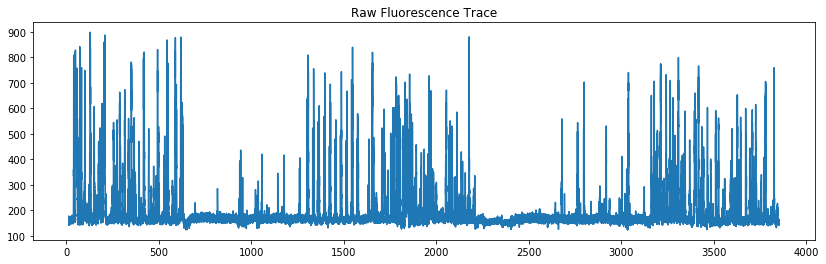

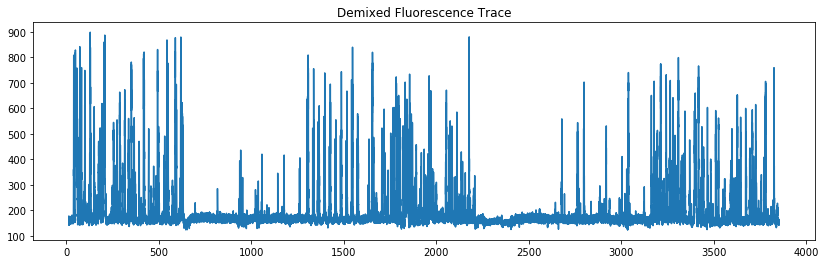

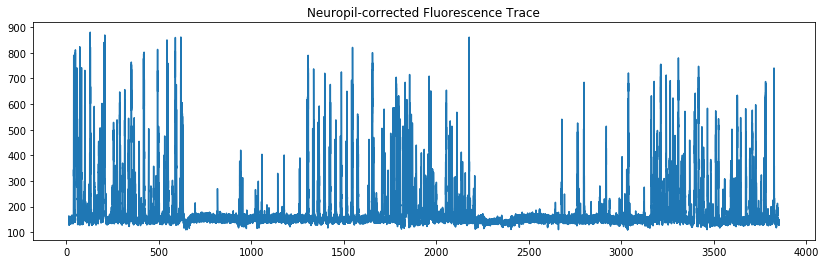

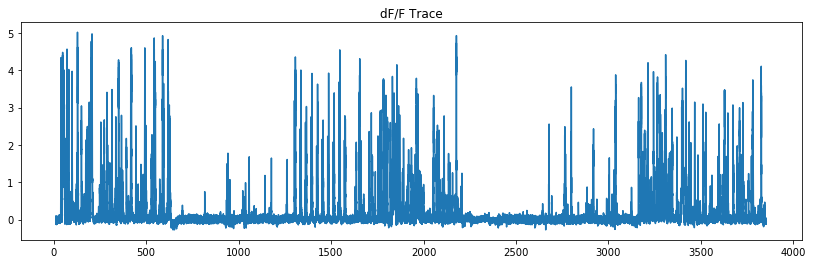

In [22]:
# plot raw and corrected ROI trace
plt.figure(figsize=(14,4))
plt.title("Raw Fluorescence Trace")
plt.plot(time, raw_traces[0])
plt.show()

plt.figure(figsize=(14,4))
plt.title("Demixed Fluorescence Trace")
plt.plot(time, demixed_traces[0])
plt.show()

plt.figure(figsize=(14,4))
plt.title("Neuropil-corrected Fluorescence Trace")
plt.plot(time, corrected_traces[0])
plt.show()

plt.figure(figsize=(14,4))
plt.title("dF/F Trace")
# warning: dF/F can occasionally be one element longer or shorter 
# than the time stamps for the original traces.
plt.plot(time[:len(dff_traces[0])], dff_traces[0])
plt.show()

## ROI Masks
If you want to take a look at the cell visually, you can open the NWB file and extract a pixel mask.  You can also pull out the maximum intensity projection of the movie for context.

In [23]:
# get the specimen IDs for a few cells
cids = expD.get_cell_specimen_ids()[:] # sequence[start:stop:10], gets every 11th element

# get masks for specific cells
roi_mask_list = expD.get_roi_mask(cell_specimen_ids=cids)

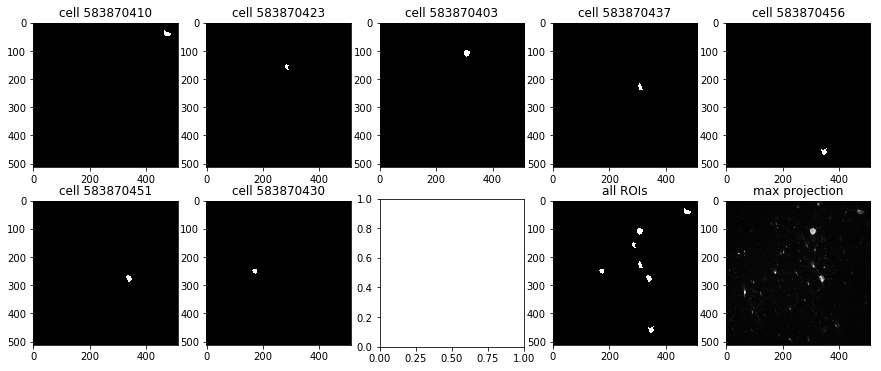

In [24]:
# plot each mask
f, axes = plt.subplots(2, int((len(cids)+2)/2)+1, figsize=(15, 6))
for ax, roi_mask, cid in zip(axes.flatten()[:-2], roi_mask_list, cids):
    ax.imshow(roi_mask.get_mask_plane(), cmap='gray')
    ax.set_title('cell %d' % cid)

# make a mask of all ROIs in the experiment    
all_roi_masks = expD.get_roi_mask_array()
combined_mask = all_roi_masks.max(axis=0)

axes.flatten()[-2].imshow(combined_mask, cmap='gray')
axes.flatten()[-2].set_title('all ROIs')

# show the movie max projection
max_projection = expD.get_max_projection()
axes.flatten()[-1].imshow(max_projection, cmap='gray')
axes.flatten()[-1].set_title('max projection')

plt.show()

## ROI Analysis
The code to compute all of the cell metrics available for download (along with several others we haven't put in our database yet) is in the AllenSDK.  All you need is an NWB file.  For example, this is how you compute metrics for the drifting gratings stimulus and plot some results.
To get more information on what precomputed metrics are available, take a look here:

    - http://alleninstitute.github.io/AllenSDK/brain_observatory.html#precomputed-cell-metrics
    - http://help.brain-map.org/download/attachments/10616846/VisualCoding_VisualStimuli.pdf?version=3&modificationDate=1497305590322&api=v2
    - http://alleninstitute.github.io/AllenSDK/allensdk.brain_observatory.html#allensdk.brain_observatory.drifting_gratings.DriftingGratings

In [25]:
%%time
from allensdk.brain_observatory.drifting_gratings import DriftingGratings

# example loading drifing grating data
dg = DriftingGratings(expD)
dg_peak = dg.get_peak() # dg.peak is alias
print("done analyzing drifting gratings")

done analyzing drifting gratings
Wall time: 1.32 s


### Inspect some metrics visually
Gives an idea what you may want to threshold on

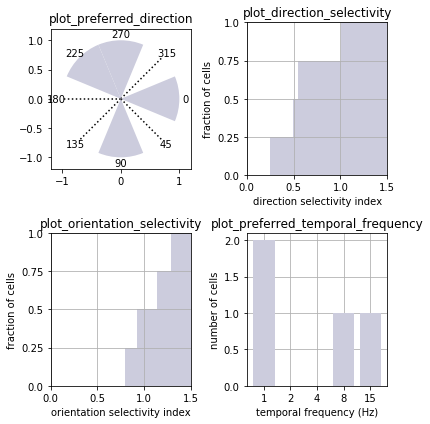

In [26]:
plots = [dg.plot_preferred_direction, 
         dg.plot_direction_selectivity, 
         dg.plot_orientation_selectivity, 
         dg.plot_preferred_temporal_frequency]
params = [dict(include_labels=True), {}, {}, {}]
f, axes = plt.subplots(int(len(plots)/2), int(len(plots)/2), figsize=(6, 6))
for ax, pl, pr in zip(axes.flatten(), plots, params):
    plt.sca(ax) # set current axis to ax
    pl(**pr) # call function from list
    ax.set_title('{}'.format(pl.__name__))

plt.tight_layout() # optimize spacing between subplots
plt.show()

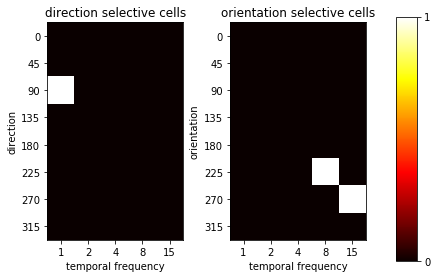

In [27]:
# DG - drifring gratings
# filter for visually responding, selective cells
# ~ Significant with pronounced peak
vis_cells = (dg_peak.ptest_dg < 0.05) &  (dg_peak.peak_dff_dg > 3)
# OSI - orientation selectivity index - compares against orthogonal direction
osi_cells = vis_cells & (dg_peak.osi_dg > 1.0) & (dg_peak.osi_dg <= 1.5)
# DSI - direction selectivity index - compares against opposite drection
dsi_cells = vis_cells & (dg_peak.dsi_dg > 1.0) & (dg_peak.dsi_dg <= 1.5)

# 2-d tf vs. ori histogram
# tfval = 0 is used for the blank sweep, so we are ignoring it here
os = np.zeros((len(dg.orivals), len(dg.tfvals)-1)) # gives orientation directions and temprofal frequencies
ds = np.zeros((len(dg.orivals), len(dg.tfvals)-1))

# Accumulate counts
for i,trial in dg_peak[osi_cells].iterrows():
    os[trial.ori_dg, trial.tf_dg-1] += 1
    
for i,trial in dg_peak[dsi_cells].iterrows():
    ds[trial.ori_dg, trial.tf_dg-1] += 1
# Get max count for comparable plotting
max_count = max(os.max(), ds.max())

fig, (ax1, ax2) = plt.subplots(1,2)

# plot direction selectivity
im = ax1.imshow(ds, clim=[0,max_count], cmap='hot', interpolation='nearest')
ax1.set_xlabel('temporal frequency')
ax1.set_ylabel('direction')
ax1.set_xticks(np.arange(len(dg.tfvals)-1))
ax1.set_xticklabels(dg.tfvals[1:])
ax1.set_yticks(np.arange(len(dg.orivals)))
ax1.set_yticklabels(dg.orivals)
ax1.set_title('direction selective cells')

# plot orientation selectivity
im = ax2.imshow(os, clim=[0,max_count], cmap='hot', interpolation='nearest')
ax2.set_xlabel('temporal frequency')
ax2.set_ylabel('orientation')
ax2.set_xticks(np.arange(len(dg.tfvals)-1))
ax2.set_xticklabels(dg.tfvals[1:])
ax2.set_yticks(np.arange(len(dg.orivals)))
ax2.set_yticklabels(dg.orivals)
ax2.set_title('orientation selective cells')

# plot a colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.05, 0.05, 0.85])
cbar = fig.colorbar(im, cax=cbar_ax)
# May need to adjust following depending on your data
cbar.set_ticks(np.arange(0, max_count+1, 1))
cbar.set_ticklabels(np.arange(0, max_count+1, 1, dtype=int))

plt.show()

## Neuropil Correction
All of the raw fluorescence traces are available in NWB files, but some of these signals are contaminated by nearby neuropil signal.  Neuropil correction is performed after the signal from overlapping traces has been demixed.  The code to perform neuropil correction is available in the AllenSDK and can be used as follows:

In [28]:
%%time
from allensdk.brain_observatory.r_neuropil import estimate_contamination_ratios

print("Current experiment {} has {} cells.".format(expD.get_metadata()['ophys_experiment_id'], expD.number_of_cells))
print("Let's pick just one cell with id: {}.".format(cellID))
# Obtain preconditioned traces
# You can find out how they obtained them here:
# http://help.brain-map.org/download/attachments/10616846/VisualCoding_Overview.pdf?version=4&modificationDate=1497305590274&api=v2
time, demixed_traces = expD.get_demixed_traces(cell_specimen_ids=[cellID])
_, neuropil_traces = expD.get_neuropil_traces(cell_specimen_ids=[cellID])

# Calling [0] on an array just reshapes it
results = estimate_contamination_ratios(demixed_traces[0], neuropil_traces[0])
correction = demixed_traces[0] - results['r'] * neuropil_traces[0]
print("r = %f" % results['r'])
print("max error = %f" % results['err'])

Current experiment 572722662 has 7 cells.
Let's pick just one cell with id: 583870410.
r = 0.126000
max error = 0.004489
Wall time: 230 ms


The NWB files contain the neuropil traces and `r` values needed to perform this correction, so you don't need to recompute them.  The corrected trace can be computed on the fly when you use the `get_corrected_fluorescence_traces` method:

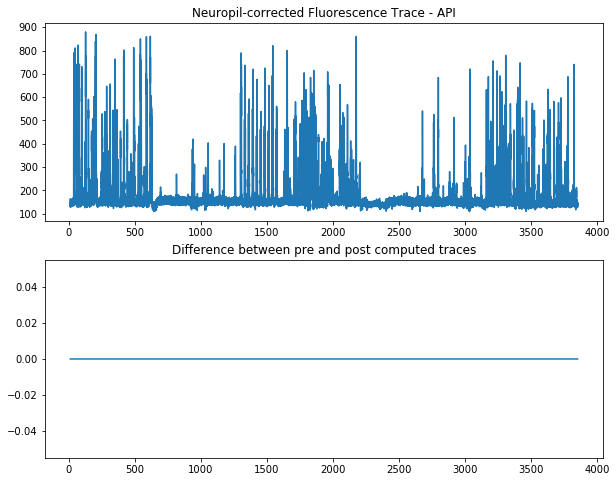

In [29]:
_, corrected_traces = expD.get_corrected_fluorescence_traces(cell_specimen_ids=[cellID])

f, axes = plt.subplots(2, 1,figsize=(10,8))
axes[0].set_title("Neuropil-corrected Fluorescence Trace - API")
axes[0].plot(time, corrected_traces[0])
axes[1].set_title("Difference between pre and post computed traces")
axes[1].plot(time, corrected_traces[0] - correction)

plt.show()

## Compute dF/F
You can compute dF/F for yourself using the `allensdk.brain_observatory.dff` module.

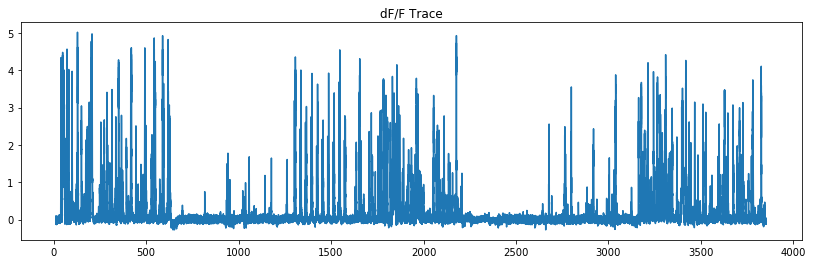

Wall time: 473 ms


In [30]:
%%time
from allensdk.brain_observatory.dff import compute_dff

plt.figure(figsize=(14,4))
plt.title("dF/F Trace")
dff = compute_dff(np.array(correction.reshape((1, -1))))# reshape to expected
plt.plot(time, dff[0,:])
plt.show()

## Running Speed
We recorded the animal's running speed during the course of the experiment and made it available in the NWB file.

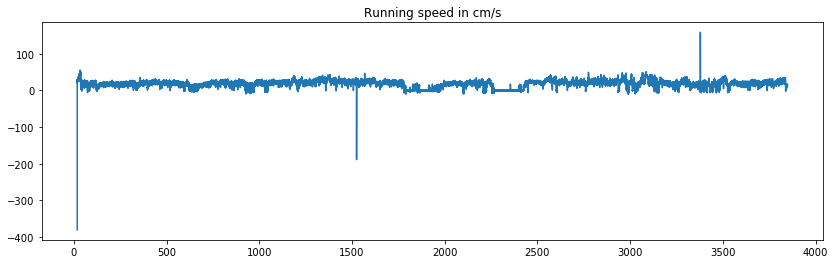

In [31]:
dxcm, dxtime = expD.get_running_speed()
plt.figure(figsize=(14,4))
plt.title("Running speed in cm/s")
plt.plot(dxtime, dxcm)
plt.show()

## Motion Correction
X and Y translation values in pixels required to correct for motion artifacts during the experiment are available as well.

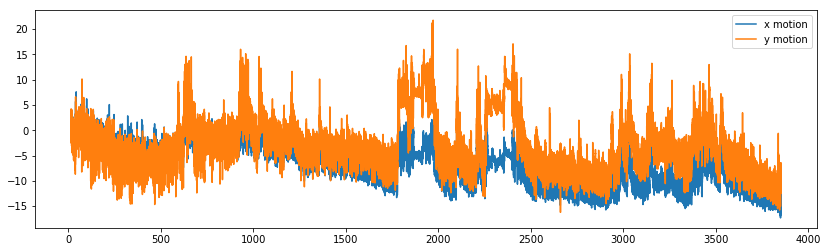

In [32]:
mc = expD.get_motion_correction()

plt.figure(figsize=(14,4))
plt.plot(mc.timestamp, mc.x_motion)
plt.plot(mc.timestamp, mc.y_motion)
plt.legend(['x motion','y motion'])
plt.show()

## Eye Tracking
Many experiments contain pupil position and pupil size from eye tracking. Extreme outliers from the tracking have been removed and replaced with NaN, which will appear as gaps in the plotted data. If an experiment does not have eye tracking data, a NoEyeTrackingException will be raised.

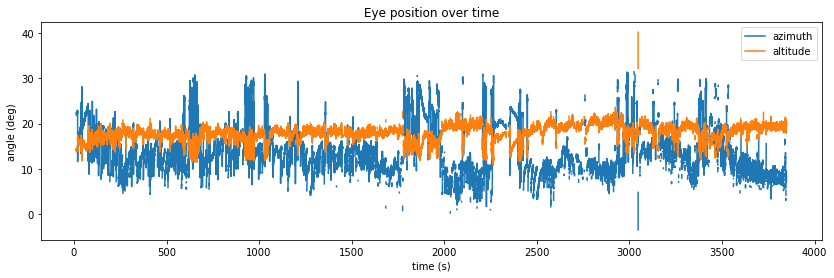

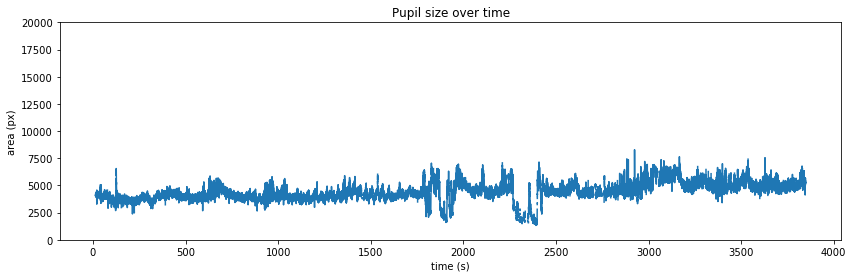

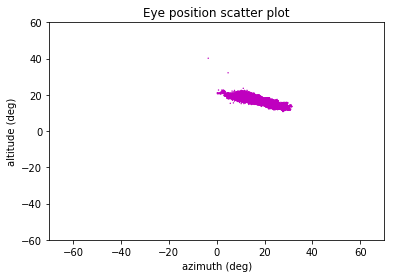

In [33]:
from allensdk.brain_observatory.brain_observatory_exceptions import NoEyeTrackingException
try:
    timestamps, locations = expD.get_pupil_location()
except NoEyeTrackingException:
    print("No eye tracking for experiment %s." % expD.get_metadata()["ophys_experiment_id"])
    assert(False)
    

## This will run only if the experiment actually has eye tracking data associated
# looking at azimuth and altitude over time
# by default locations returned are (azimuth, altitude)
# passing as_spherical=False to get_pupil_location will return (x,y) in cm
timestamps, locations = expD.get_pupil_location()
plt.figure(figsize=(14,4))
plt.plot(timestamps, locations.T[0])
plt.plot(timestamps, locations.T[1])
plt.title("Eye position over time")
plt.xlabel("time (s)")
plt.ylabel("angle (deg)")
plt.legend(['azimuth', 'altitude'])
plt.show()

#pupil size over time
timestamps, area = expD.get_pupil_size()
plt.figure(figsize=(14,4))
plt.plot(timestamps, area)
plt.title("Pupil size over time")
plt.xlabel("time (s)")
plt.ylabel("area (px)")
plt.ylim(0, 20000)
plt.show()

# scatter of gaze positions over approximate screen area
plt.figure()
plt.scatter(locations.T[0], locations.T[1], s=2, c="m", edgecolor="")
plt.title("Eye position scatter plot")
plt.xlim(-70, 70)
plt.ylim(-60, 60)
plt.xlabel("azimuth (deg)")
plt.ylabel("altitude (deg)")
plt.show()

## Analyse receptive fields
    - based on notebook from here: http://alleninstitute.github.io/AllenSDK/_static/examples/nb/receptive_fields.html
Given a cell of interest, we identify the experiment that contains the locally sparse noise stimulus and download its NWB file. We also look in the NWB file to figure out the position/index of the cell that has the ID we're interested in.
***
Here is some code that we dont use anymore:

In [131]:
# Next look through these experiments to find those that have such a stimuli, that you desire
# btw there is no such cell that would fullfil stim = ['drifting_gratings', 'locally_sparse_noise_8deg']
# stim = [stim_info.LOCALLY_SPARSE_NOISE_8DEG, stim_info.LOCALLY_SPARSE_NOISE_4DEG]
# Note that expIDs already were depth, cre-line, brain-area filtered
# stimIDs = [x for x in expIDs if all(s in boc.get_ophys_experiment_stimuli(x) for s in stim)]
# print("Experiments with desired stimuli: %d" % len(stimIDs))
# print("The experiment IDs are:{}".format(stimIDs))
# Pull out correspoding experiment container IDs
# expContIDs_sel = [x['experiment_container_id'] for y in exps for x in y if (x['id'] in stimIDs)]
# print("The corresponding experiment container IDs are:{}".format(expContIDs_sel))

Experiments with desired stimuli: 6
The experiment IDs are:[577720111, 575795843, 572376868, 555327035, 557199402, 573865128]


In [171]:
# %%time
# ## Make a different selection to have plottable data

# # Finally extract cells, convert to DataFrame, and pull out only those that have needed params
# cells = boc.get_cell_specimens(experiment_container_ids = expContIDs_sel)
# cells = pd.DataFrame.from_records(cells)
# print("total cells: %d" % len(cells))
# # you can interact with DF using usual pandas methods

# req_met = "rf_chi2_lsn"
# cells_sel = cells[cells[req_met].notnull() & (cells[req_met] < 5e-2)] # take only such cells that have required stimuli associated and significant
# print("Number of cells where '{}' is not NaN and where '{}' is less than 0.05: {}".format(req_met, req_met, len(cells_sel)))

# cellID = cells_sel.iloc[0]['cell_specimen_id']
# print("Selected cell has ID {}".format(cellID))

total cells: 384
Number of cells where 'rf_chi2_lsn' is not NaN and where 'rf_chi2_lsn' is less than 0.05: 50
Selected cell has ID 557374653
Wall time: 2.81 s


***
Pull out a cell from our previous selection and have some more strict requirements on it.

In [34]:
cellRF = cellsBO[(cellsBO['all_stim'])
    & (cellsBO['rf_chi2_lsn'] > 0.9*cellsBO['rf_chi2_lsn'].max())]

cellID = cellRF['cell_specimen_id'].values[0]
print("{} cell(s) fit the criteria. Picking cell {}.".format(len(cellRF), cellID))

2 cell(s) fit the criteria. Picking cell 560389965.


For analysis of receptive fields we look at such experiments that have locally sparse noise stimuli defined.

In [35]:
%%time
import allensdk.brain_observatory.receptive_field_analysis.visualization as rfvis
# http://alleninstitute.github.io/AllenSDK/allensdk.brain_observatory.receptive_field_analysis.html#allensdk.brain_observatory.receptive_field_analysis.visualization
import allensdk.brain_observatory.receptive_field_analysis.receptive_field as rf
# http://alleninstitute.github.io/AllenSDK/allensdk.brain_observatory.receptive_field_analysis.html#module-allensdk.brain_observatory.receptive_field_analysis.receptive_field

stim = [stim_info.LOCALLY_SPARSE_NOISE_8DEG, stim_info.LOCALLY_SPARSE_NOISE_4DEG]
expsRF = boc.get_ophys_experiments(cell_specimen_ids=[cellID],
                                 stimuli=stim)
print("There is {} experiment(s) for given query.".format(len(expsRF)))

There is 1 experiment(s) for given query.
Wall time: 2.37 s


In [36]:
%%time
# Get experiment data, this will take some time
expDRF = boc.get_ophys_experiment_data(expsRF[0]['id']) # pick an experiment from the top of the stack
cell_ids = expDRF.get_cell_specimen_ids()
print("There is {} cell(s) for given experiment.".format(len(cell_ids)))

# get the index of the cell in this experimentb
cell_index = expDRF.get_cell_specimen_indices([cellID])[0]
print("Our initial cell %d has index %d." % (cellID, cell_index))

There is 89 cell(s) for given experiment.
Our initial cell 560389965 has index 5.
Wall time: 0 ns


In [37]:
# List available stimuli
print("Avalaible stimuli in 'expsRF' are:")
for exp in expsRF:
    print(boc.get_ophys_experiment_stimuli(exp['id']))

Avalaible stimuli in 'expsRF' are:
['locally_sparse_noise_4deg', 'locally_sparse_noise_8deg', 'natural_movie_one', 'natural_movie_two', 'spontaneous']


### Compute receptive fields
The following method in the receptive_field_analysis module will characterize on and off receptive fields and perform a per-pixel significance test.

#### Look at 8 degree stimulus
For data released in June 2017, the Session C stimulus was adapted to the Session C2 stimulus (Fig. 4). This 
stimulus session included 24 minutes of the Locally Sparse Noise 4 degree stimulus described above and 23 
minutes of Locally Sparse Noise 8 degree stimulus. This second stimulus consisted of an 8 x 14 array made 
simply by scaling the 16 x 28 array used for the 4 degree stimulus. Please note, while the name of the stimulus 
is Locally Sparse Noise 8 degree, the actual pixel size is 9.3 degrees. The exclusions zone of 5 pixels was 46.5 
degrees. This larger pixel size was found to be more effective at eliciting responses in the higher visual areas. 
Metrics and visualization for the higher visual areas (everything other than VISp) were computed using the “8 degree” stimulus, while the metrics and visualizations for VISp were computed using the “4 degree” stimulus. 

In [38]:
%%time
# Equivalent to:
# rf_data = rf.compute_receptive_field(expDRF,cell_index, stim_info.LOCALLY_SPARSE_NOISE, alpha=0.5, number_of_shuffles = 10000)
# import allensdk.brain_observatory.receptive_field_analysis.postprocessing as postproc
# rf_data = postproc.run_postprocessing(expDRF, rf_data)

rf_data = rf.compute_receptive_field_with_postprocessing(expDRF, 
                                                         cell_index, 
                                                         stim_info.LOCALLY_SPARSE_NOISE_8DEG, 
                                                         alpha=0.5, 
                                                         number_of_shuffles=10000)

Wall time: 35.5 s


C:\Users\MartinH.PHARPCMORPHWK1\Miniconda2\envs\ein\lib\site-packages\allensdk\brain_observatory\receptive_field_analysis\chisquarerf.py:245: RuntimeWarning: invalid value encountered in divide
  chi = (residual_by_pixel ** 2) / expected_by_pixel


### Chi^2 significance map
Per-pixel chi-square tests identify cells that show non-uniform distributions of responses across pixels. The receptive_field_analysis.visualization module has function to plot that significance as a heat map

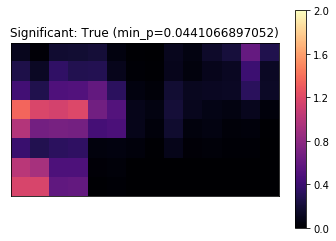

In [39]:
rfvis.plot_chi_square_summary(rf_data)
plt.show()

### Blurred response-triggered stimulus field
The response-triggered stimulus field shows, for a given pixel, how many trials contained a detected calcium event.
The RTS field is convolved with a Gaussian to pool the contributions of neighboring stimulus pixels.

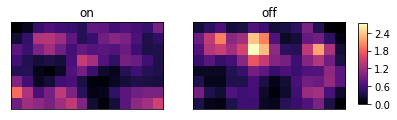

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2)
rfvis.plot_rts_blur_summary(rf_data, ax1, ax2)

### p value field
Per-pixel p-values are estimated from the blurred RTS field to understand the significance of the response to each pixel.

### Significance mask
The significance mask is p-value field after applying a binary threshold to remove insignificant pixels.

### Gaussian fit
Each identified subunit of the on and off receptive fields are fit with a Gaussian in the receptive_field_analysis.postprocessing module

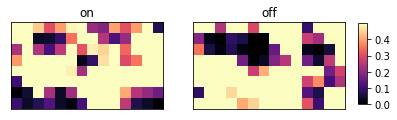

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2)
rfvis.plot_p_values(rf_data, ax1, ax2)

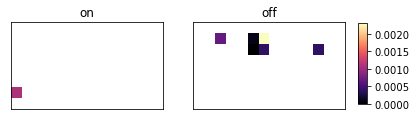

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2)
rfvis.plot_mask(rf_data, ax1, ax2)

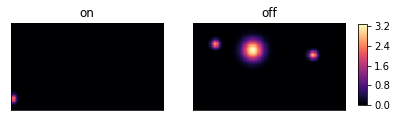

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2)
rfvis.plot_gaussian_fit(rf_data, ax1, ax2)

<a id="CT"></a>
# Cell Types Database
Let's now come back to the __[Cell Types Database](http://celltypes.brain-map.org/)__ we have introduced earlier and look on the data contained within. We will again focus on the same regions of brain as with __[Brain Observatory Database](http://observatory.brain-map.org/visualcoding/)__ because that's where the provided data comes from.

## Filtering Cells via Metadata
Cell records in the Cell Types Database come with a large amount of metadata. We have exposed the most commonly used of these are arguments to CellTypesCache.get_cells.

***
Recall that we have saved our refined cells in cellCT_sel and their ids in cell_ids_CT.
Note also that we already required certain depth, presence of reconstruction and that the cells come from cre- reporter negative experiments. We will now pick a specific cell based on some electrophysiology feature.
You can get a feeling of available information for example __[here](http://celltypes.brain-map.org/mouse/experiment/electrophysiology/486111903)__ or by typing `cellCT_sel[0]['ephys_features']`. You may also want to read __[their whitepaper on electrophysiology measurements](http://help.brain-map.org/display/celltypes/Documentation?preview=/8323525/10813529/CellTypes_Ephys_Overview.pdf)__.

In [47]:
print("{} cells available matching our criteria".format( len(cellCT_sel)))
#cell['ephys_features']['thr']
sel_feature = 'threshold_i_long_square'
cellCT_sel_ephys = [[cell['ephys_features'][0][sel_feature], cell['id']] for cell in cellCT_sel]
cellCT_sel_ephys = np.asarray(cellCT_sel_ephys, dtype = np.int)
cellID = cellCT_sel_ephys[np.argmin(cellCT_sel_ephys[:,0]), 1]
print("Sellected cell {} has value of {} for {}.".format(cellID, 
                                                        cellCT_sel_ephys[np.argmin(cellCT_sel_ephys[:,0]), 0],
                                                        sel_feature))

6 cells available matching our criteria
Sellected cell 512319604 has value of 40 for threshold_i_long_square.


In [48]:
# download and open an SWC file
# cell_id = 502574847 # this one doesnt have reconstruction
# cell_id = 485911892 # this one doesnt have markers
# cell_id = 485912047 # this one is also suitably located and fulfills requirements
morphology = ctc.get_reconstruction(cellID) 

# the compartment list has all of the nodes in the file
pprint.pprint(morphology.compartment_list[0])

{'children': [1, 270, 302, 1063],
 'id': 0,
 'parent': -1,
 'radius': 10.1146,
 'tree_id': 0,
 'type': 1,
 'x': 627.3845,
 'y': 481.5325,
 'z': 29.96}


Note that the type field refers to the type of neuronal compartment. The values can be 1 for the soma, 2 for the axon, 3 for dendrites, and 4 for apical dendrites (if present).
Morphologies now also come with marker files, which contains points of interest in the reconstruction. The marker file contains locations where dendrites have been truncated due to slicing and when axons were not reconstructed. The name field indicates the type of marker (10 for dendrite truncation, 20 for no reconstruction).

In [49]:
# download and open a marker file
markers = ctc.get_reconstruction_markers(cellID) 
print len(markers)
pprint.pprint(markers[0])

5
{'name': 10, 'x': 760.2062999999999, 'y': 507.6752, 'z': 22.959999999999997}


We can use this data to draw lines between each node and all its children to get a drawing of the cell. We'll do it looking at it from the front and from the side.

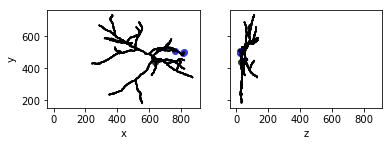

Wall time: 18.9 s


In [50]:
%%time
from allensdk.core.swc import Marker
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box-forced')
axes[1].set_aspect('equal', 'box-forced')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

# cut dendrite markers
dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]

axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]

axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
plt.show()

## Electrophysiology Features

The Cell Types Database contains a set of features that have already been computed, which could serve as good starting points for analysis. We can query the database using the SDK to get these features. You can learn more about the precomuted features __[here](http://help.brain-map.org/display/celltypes/Documentation?preview=/8323525/10813529/CellTypes_Ephys_Overview.pdf)__. Later we will also show that you can compute additional features yourself.

In [51]:
%%time
pp = pprint.PrettyPrinter(indent=2)

# download all electrophysiology features for all cells
# it is not pissible to call .get_ephys_features w/ cell specimen id =.=
ephys_features = ctc.get_ephys_features()

print("Ephys. features available for %d cells" % len(ephys_features))

# filter down to a specific cell
print("Ephys. features for cell %d " % cellID)
cell_ephys_features = [cell for cell in cellCT_sel if cell['id'] == cellID][0]['ephys_features']
pp.pprint(cell_ephys_features)

Ephys. features available for 977 cells
Ephys. features for cell 512319604 
[ { u'adaptation': 0.0458338627977132,
    u'avg_isi': 87.28,
    u'electrode_0_pa': 16.0224992995506,
    u'f_i_curve_slope': 0.139989118607182,
    u'fast_trough_t_long_square': 1.36326,
    u'fast_trough_t_ramp': 3.20065333333333,
    u'fast_trough_t_short_square': 1.02524,
    u'fast_trough_v_long_square': -45.8125038146973,
    u'fast_trough_v_ramp': -45.8958371480306,
    u'fast_trough_v_short_square': -49.6812530517578,
    u'has_burst': False,
    u'has_delay': False,
    u'has_pause': False,
    u'id': 512321774,
    u'input_resistance_mohm': 121.2268,
    u'latency': 0.04772,
    u'peak_t_long_square': 1.36056,
    u'peak_t_ramp': 3.19718,
    u'peak_t_short_square': 1.02308,
    u'peak_v_long_square': 40.9687538146973,
    u'peak_v_ramp': 40.6250025431315,
    u'peak_v_short_square': 39.7875022888184,
    u'rheobase_sweep_id': 512321309,
    u'rheobase_sweep_number': 41,
    u'ri': 161.250039935112,


## Morphology Features

The Cell Types Database contains a set of precomputed morphological features for cells that have reconstructions.  You can access morphology features by themselves, or combined with the electrophysiology features.

In [52]:
%%time
# download all morphology features for cells with reconstructions
morphology_features = ctc.get_morphology_features()
print("Morphology features available for %d cells" % len(morphology_features))

print("Morphology features for cell  %d" % (cellID))
cell_morphology_features = [f for f in morphology_features if f['specimen_id'] == cellID]
pp.pprint(cell_morphology_features)

Morphology features available for 295 cells
Morphology features for cell  512319604
[ { 'average_bifurcation_angle_local': 80.3061958262246,
    'average_bifurcation_angle_remote': nan,
    'average_contraction': 0.8608320924705402,
    'average_diameter': 0.434087755248188,
    'average_fragmentation': 93.61111111111109,
    'average_parent_daughter_ratio': 0.882438369829616,
    'hausdorff_dimension': nan,
    'id': 527109189L,
    'max_branch_order': 8.0,
    'max_path_distance': 464.50302511160004,
    'number_bifurcations': 18L,
    'number_branches': 39L,
    'number_nodes': 3413L,
    'number_stems': 3L,
    'number_tips': 21L,
    'overall_depth': 116.1154,
    'overall_height': 498.258568795189,
    'overall_width': 669.518764584386,
    'scale_factor_x': 0.1144,
    'scale_factor_y': 0.1144,
    'scale_factor_z': 0.28,
    'soma_surface': 798.7928963735719,
    'specimen_id': 512319604L,
    'tags': '3D Neuron Reconstruction morphology',
    'total_length': 3892.45163565933,


## Computing Electrophysiology Features

The AllenSDK contains the code used to compute the electrophysiology features you accessed above.  You can run it yourself like this.

In [53]:
%%time
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

# this saves the NWB file to 'cell_types/specimen_464212183/ephys.nwb'
data_set = ctc.get_ephys_data(cellID)

# data_set.get_sweep_numbers()
sweep_number = 35
sweep_data = data_set.get_sweep(sweep_number)
sweep_metadata = data_set.get_sweep_metadata(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

# stimulus begins at 1.02
sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
sweep_ext.process_spikes() # Analyze spike features for all sweeps.

print "Avg spike threshold: {:.1f} mV".format(sweep_ext.spike_feature("threshold_v").mean())
print "Avg spike width: {:.2f} ms".format(1e3 * np.nanmean(sweep_ext.spike_feature("width")))

Avg spike threshold: -36.4 mV
Avg spike width: 1.02 ms
Wall time: 124 ms


We can look at when the spikes occur by looking at the `threshold_t` property (i.e., time of spike threshold).

In [54]:
spike_times = sweep_ext.spike_feature("threshold_t")

print(spike_times[:5])  # print just the first 5 spike times

[ 1.05234  1.0823   1.12584  1.17726  1.23452]


### Plot spike starts

extract threshold voltage value from data file and mark it in the plot

(1.015, 1.8)

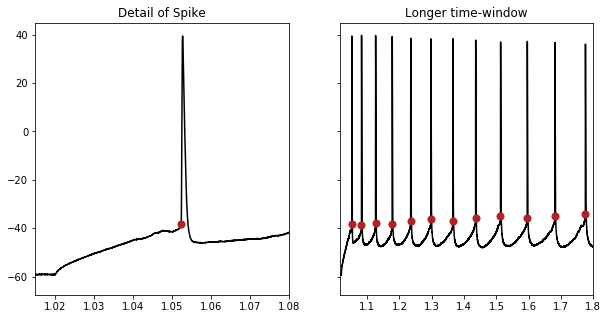

In [55]:
threshold_v = sweep_ext.spike_feature("threshold_v")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), sharey=True)
ax1.plot(t, v, color='black')
ax1.set_title('Detail of Spike')
# setting zorder puts the dots on top of the trace
ax1.scatter(spike_times, threshold_v, s=50, c='firebrick', zorder=20)
ax1.set_xlim(1.015, 1.08)

ax2.plot(t, v, color='black')
ax2.set_title('Longer time-window')
# setting zorder puts the dots on top of the trace
ax2.scatter(spike_times, threshold_v, s=50, c='firebrick', zorder=20)
ax2.set_xlim(1.015, 1.8)

## Ephys features - more in detail
Let's review what ephys features we have available and play around with them a bit:

## Cell Types - RNA Seq
The Allen Brain Atlas also provides RNA-Seq data. These come only from the dorsal part of the lateral geniculate complex (LGd) and two mouse neocortical areas: primary visual cortex (VISp) and anterior lateral motor area (ALM).
Toegther with EPys and Morphology features, these infromation aim to enable classification of cells into individual cell types. Most of the focus is on neurons but RNA-Seq database also provides information on non-neuron type of cells. You can learn more about the transcriptomics profiling by reading the __[whitepaper in documentation](http://help.brain-map.org/display/celltypes/Documentation?preview=/8323525/10813526/CellTypes_Transcriptomics_Overview.pdf)__.
This data is again the most easily accessible via the online interface. (No API access is provided, alhough some files can be downloaded.)